In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cnmfsns as cn
cn.start_logging()

## Working with `Dataset` objects

Datasets can be created from pandas DataFrames quite easily.

In [3]:
import pandas as pd

data = pd.read_table("diamandis_data/diamandis_nobulk.txt", index_col=0)  # normalized expression data
metadata = pd.read_table("diamandis_data/diamandis_nobulk.metadata.txt", index_col=0)  # sample metadata

# create dataset from DataFrames
diamandis = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col="patient_id")

They can be written to and read from AnnData files (h5ad format).

In [4]:
diamandis.write_h5ad("diamandis.h5ad")  # write to .h5ad file
diamandis = cn.Dataset.from_h5ad("diamandis.h5ad")  # read a .h5ad file

2023-03-06 11:24:04,598 [INFO] Writing to /home/tbverhey/github/cNMF-SNS/example/diamandis.h5ad
2023-03-06 11:24:04,629 [INFO] Done


`Dataset` objects contain an AnnData object which can also be used for interfacing with other tools

In [5]:
diamandis.adata

AnnData object with n_obs × n_vars = 77 × 3560
    obs: 'patient_id', 'simple_category', 'detailed_category', 'age', 'sex', 'location of resection', 'ATRX', 'p53', 'MGMT'
    uns: 'cnmfsns_version', 'history', 'is_normalized', 'odg'

cNMF-SNS can recognize and import AnnData .h5ad files whether they are created in [Seurat](https://satijalab.org/seurat/archive/v2.4/conversion_vignette.html), [scanpy](https://scanpy.readthedocs.io/en/stable/usage-principles.html#anndata), or other single-cell software tools.

In [6]:
import scanpy

pbmc_adata = scanpy.datasets.pbmc3k()
pbmc_dataset = cn.Dataset.from_anndata(pbmc_adata)

## Modelling mean and dispersion of genes

In [7]:
diamandis.compute_gene_stats()
diamandis.adata.var.head()  # results are stored in dataset object

,mean,rank_mean,variance,sd,missingness,log_mean,log_variance,mean_counts,odscore_excluded,resid_log_variance,odscore,gam_fittedvalues,vscore
A1BG,1.839333e+07,2152.0,1.787097e+14,1.336824e+07,0.0,7.264660,14.252150,1.839333e+07,False,0.090640,1.109992,14.161510,1.621348
A2M,2.338366e+08,3351.0,2.278611e+16,1.509507e+08,0.0,8.368914,16.357672,2.338366e+08,False,0.040063,1.047204,16.317609,4.806647
AAAS,2.478940e+06,203.0,9.438756e+11,9.715326e+05,0.0,6.394266,11.974916,2.478940e+06,False,-0.186994,0.806312,12.161910,0.077113
AAK1,1.713328e+07,2096.0,2.520759e+14,1.587690e+07,0.0,7.233840,14.401531,1.713328e+07,False,0.294975,1.404389,14.106556,2.489859
AARS1,1.069756e+08,3146.0,9.684865e+14,3.112052e+07,0.0,8.029285,14.986094,1.069756e+08,False,-0.652043,0.472040,15.638137,0.763087


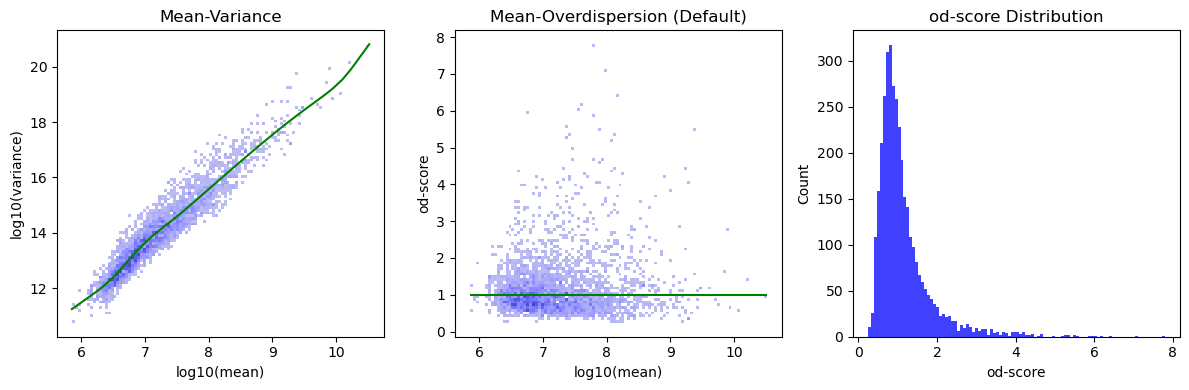

In [8]:
figs = cn.plot_feature_dispersion(diamandis, show_selected=False)

## Selecting overdispersed genes

2023-03-06 11:24:07,921 [INFO] 1612 genes selected for factorization


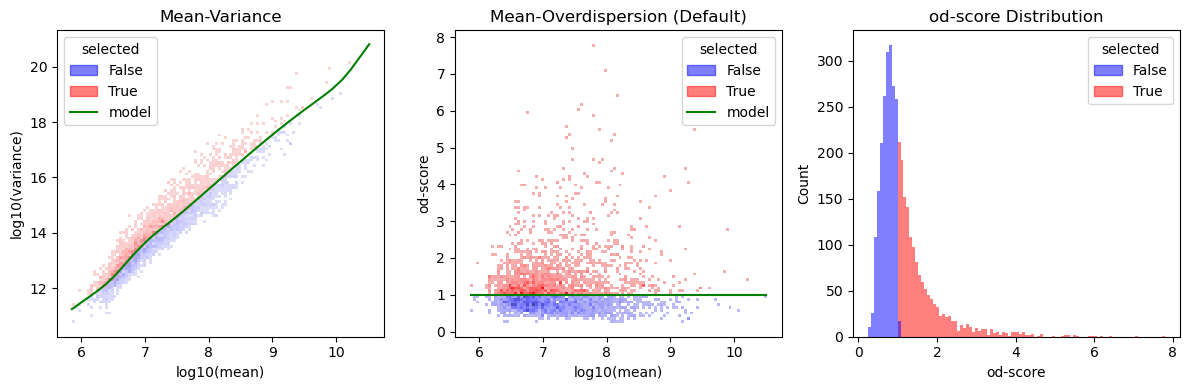

In [9]:
diamandis.select_overdispersed_genes()
figs = cn.plot_feature_dispersion(diamandis, show_selected=True)

Default parameters for `select_overdispersed_genes()` results in about 50% of genes as being overdispersed:

In [10]:
diamandis.adata.var["selected"].value_counts()

False    1948
True     1612
Name: selected, dtype: int64

## Factorization

In [11]:
cnmf_results_dir = "cnmf_results"
run_name = "diamandis"
# by default, k=2-60 is run with n_iter=200. For this demo, we will speed it up by drastically subsetting.
kvals = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
kvals = [2, 3 ,4, 5, 6, 7, 8]
n_iter = 10

cnmf_run = diamandis.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)

cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
diamandis.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
diamandis.write_h5ad("diamandis.h5ad")  # overwrite original file

2023-03-06 11:24:14,696 [INFO] Factorization outputs (merged iterations) were found for all values of k.
2023-03-06 11:24:14,697 [INFO] Creating consensus GEPs and usages using 1 CPUs
2023-03-06 11:24:14,698 [INFO] Creating consensus GEPs and usages for k=2
2023-03-06 11:24:16,519 [INFO] Creating consensus GEPs and usages for k=3
2023-03-06 11:24:18,551 [INFO] Creating consensus GEPs and usages for k=4
2023-03-06 11:24:21,040 [INFO] Creating consensus GEPs and usages for k=5
2023-03-06 11:24:24,301 [INFO] Creating consensus GEPs and usages for k=6
2023-03-06 11:24:26,508 [INFO] Creating consensus GEPs and usages for k=7
2023-03-06 11:24:29,410 [INFO] Creating consensus GEPs and usages for k=8
2023-03-06 11:24:41,753 [INFO] Importing GEPs: gene_spectra_score
2023-03-06 11:24:42,677 [INFO] Importing GEPs: gene_spectra_tpm
2023-03-06 11:24:43,552 [INFO] Importing GEPs: spectra
2023-03-06 11:24:43,965 [INFO] Importing Usages
2023-03-06 11:24:43,989 [INFO] Writing to /home/tbverhey/github/c

## Stability-Error Plot

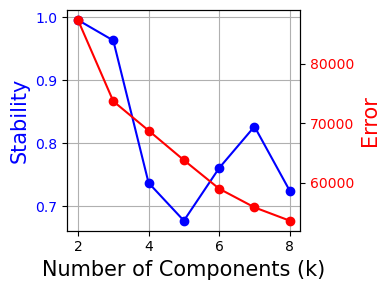

In [12]:
fig = cn.plot_stability_error(diamandis, figsize=[4,3])

fig.savefig("stability-error.pdf")  # Save figures in PDF or PNG format

## Plot GEP usage

In [13]:
diamandis.get_usages()

2                      3                            \
                  1          2           1           2            3    
sample_1   286597.84  67712.414  275941.280  53111.8480   34184.4570   
sample_10  275658.90  42802.080  225158.830  31761.4450   65190.9140   
sample_11  304356.00  46748.445  314794.000  33331.1450   15850.0290   
sample_12  325621.12  24970.639  351076.340  10833.2030    5084.4395   
sample_13  322851.84   9976.676  274420.720   3467.6870   61108.4260   
...              ...        ...         ...         ...          ...   
sample_75  381589.84   4267.814   20326.104   2127.8110  330411.0000   
sample_76  341002.56   7623.598   72567.110   4259.8315  249501.8900   
sample_77  376117.56   5305.580   36787.516   3750.3425  310460.7800   
sample_8   296365.75  25560.828  304698.700  12925.6320   17169.4590   
sample_9   353587.47  23759.482  359604.750  12480.5410   19854.5780   

                   4                                                 5   ...  \
                   1           2            3            4           1   ...   
sample_1   194185.880  37948.6250   24432.8160  118489.5800  194035.830  ...   
sample_10  164724.900  21922.2730   58012.9400   84583.1600   93475.555  ...   
sample_11  291080.620  30175.0500   13102.1860   11844.1570   42936.020  ...   
sample_12  328233.840   9123.1370    3118.7676    6942.2783  277003.280  ...   
sample_13  237561.520   1417.8694   58118.6880   34221.4020  100149.450  ...   
...               ...         ...          ...          ...         ...  ...   
sample_75   16110.913   1467.1956  331733.7000    3978.3892   13914.136  ...   
sample_76   58567.926   2541.1475  248209.0200   17646.6430   26854.020  ...   
sample_77   32854.940   2868.7110  309312.9700    5931.2330   13542.383  ...   
sample_8   182820.550   1984.1330    5583.2563  168630.4500  172776.690  ...   
sample_9   337826.800  11129.4510   17330.3790    4923.5513   70581.920  ...   

                     20                                                       \
                     11            12           13           14           15   
sample_1    2201.662800    2752.67200   486.780000   1485.39560    922.16660   
sample_10  35188.043000     462.79123   489.557920   2849.07420   1967.96500   
sample_11   7708.362300     750.84406   694.990000   1291.82170    198.78574   
sample_12   4046.273000     221.35757  1065.695900   4295.17040   4266.63960   
sample_13   9440.849000     367.15485   443.944200  10625.88000   5549.45850   
...                 ...           ...          ...          ...          ...   
sample_75    726.298000  157694.62000   201.160700    318.47733   1180.11740   
sample_76   3563.766800      92.04025   139.249390   7192.59960    587.51090   
sample_77     19.437977   51003.15600    46.726673    209.34320    479.03546   
sample_8   13002.766000     132.32310  3668.303500   4262.55270  17676.19300   
sample_9      28.174820     256.60490    30.946482  15248.46100    604.32230   

                                                                           
                    16          17          18            19           20  
sample_1    3678.89670  7162.32200  23802.7420    3068.24560  47222.17600  
sample_10   7363.42240  4188.61960   9190.9510   16381.77050    655.73000  
sample_11   2699.88230  4096.70850   9898.4430     840.64390   1909.08670  
sample_12   3842.11200   416.41116   3516.4285   10067.65100   4420.68000  
sample_13  26931.17000  2049.74490  26320.6050    3067.09280   2705.79600  
...                ...         ...         ...           ...          ...  
sample_75  15426.05300   858.77026   2256.5513   14686.58200    210.20016  
sample_76   1312.83220   377.17080   1521.3796    1888.88340    152.04156  
sample_77    241.48305  1397.19230  27239.8540      39.74621    773.17566  
sample_8    3152.72200   864.48070   3994.5234     709.29650  16658.70300  
sample_9    2311.91670   108.71217   3511.0278  101757.59000    167.55650  

[77 rows x

2023-03-06 11:24:45,053 [INFO] Choosing distinct colors for metadata layer patient_id
2023-03-06 11:24:45,265 [INFO] Choosing distinct colors for metadata layer simple_category
2023-03-06 11:24:45,296 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-03-06 11:24:45,326 [INFO] Choosing distinct colors for metadata layer sex
2023-03-06 11:24:45,338 [INFO] Choosing distinct colors for metadata layer location of resection
2023-03-06 11:24:45,461 [INFO] Choosing distinct colors for metadata layer ATRX
2023-03-06 11:24:45,472 [INFO] Choosing distinct colors for metadata layer p53
2023-03-06 11:24:45,487 [INFO] Choosing distinct colors for metadata layer MGMT


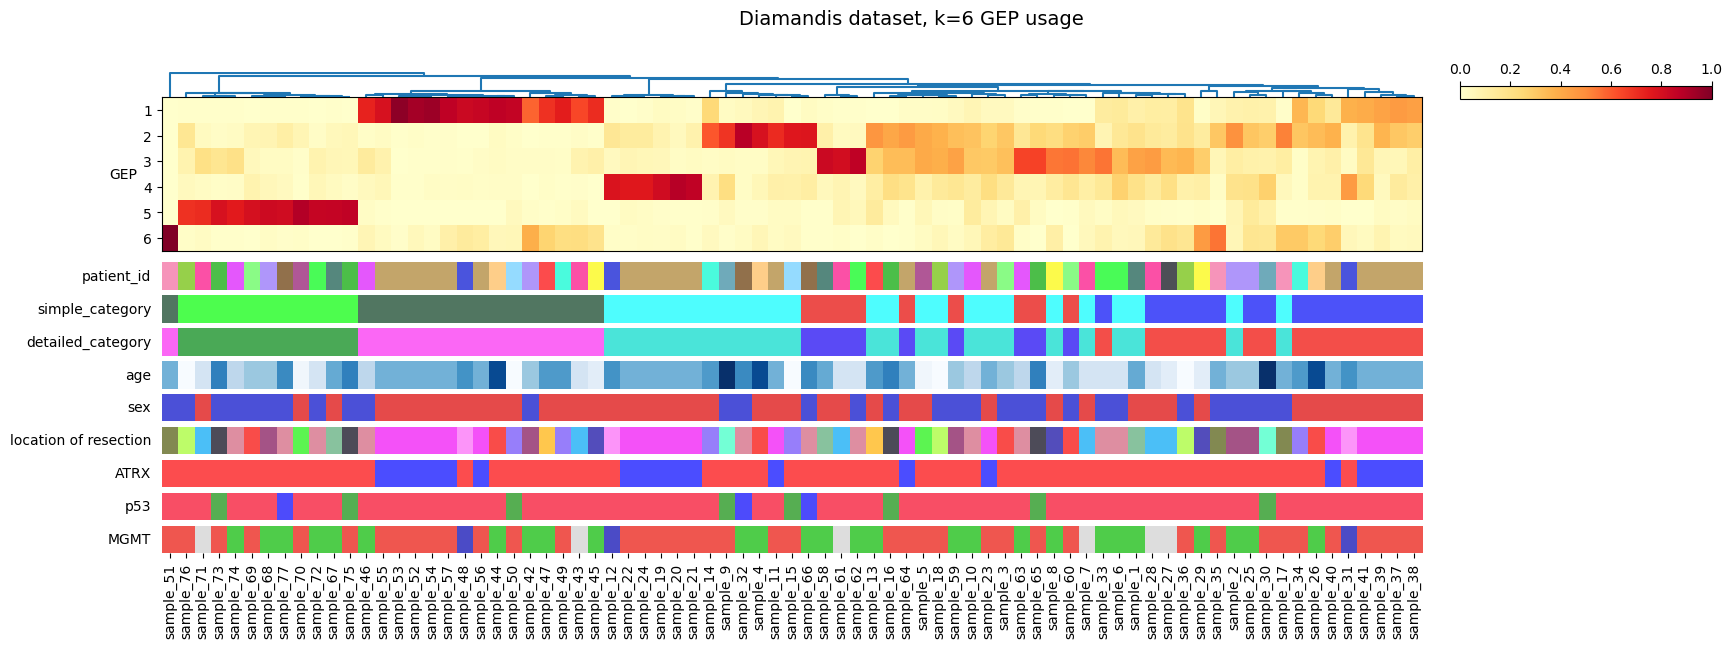

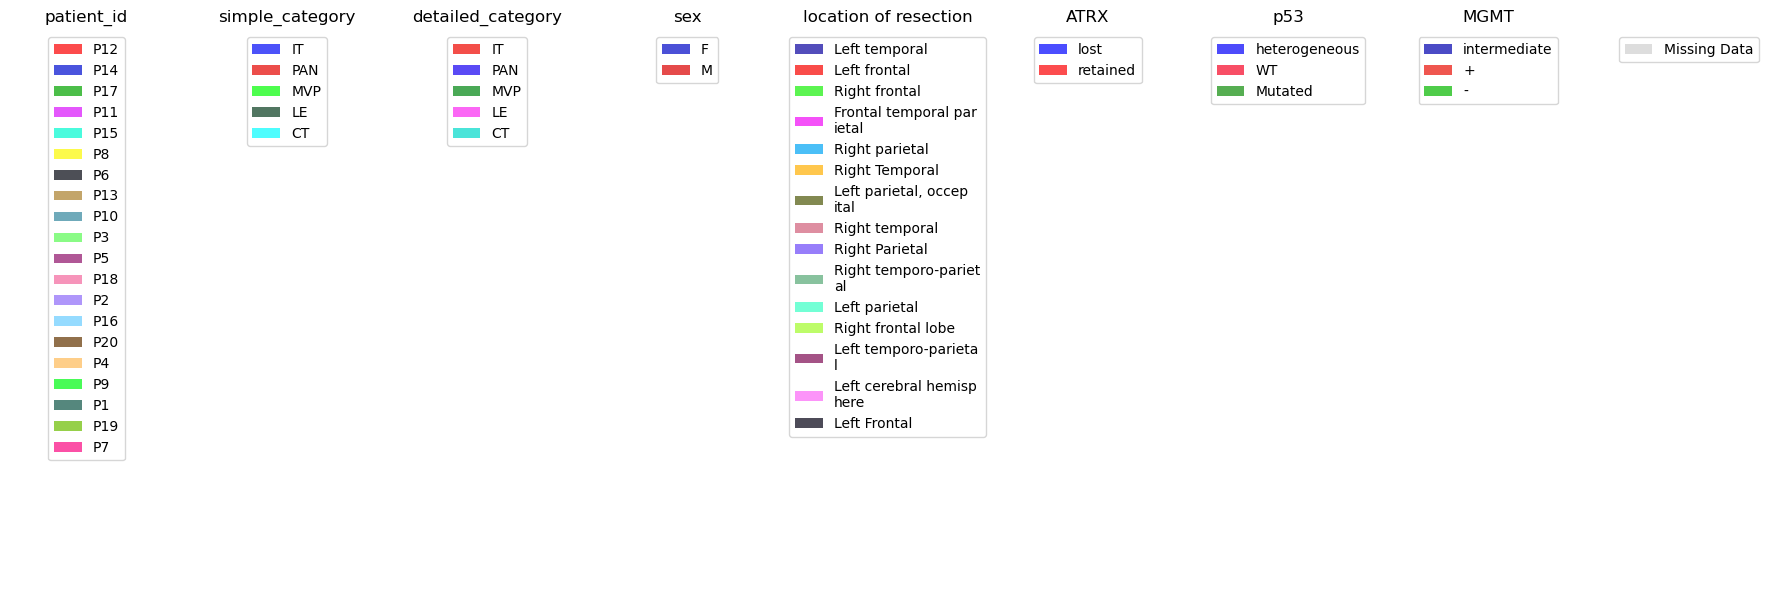

In [14]:
colors = cn.Colors.from_dataset(diamandis, pastel_factor=0.4)  # create distinct colors for metadata tracks


fig = cn.plots.plot_annotated_usages(diamandis, k=6, colors=colors,
                                     title="Diamandis dataset, k=6 GEP usage")
fig.savefig("k6_usages_heatmap.pdf")

fig_legend = colors.plot_metadata_colors_legend()
fig.savefig("diamandis_metadata_colors_legend.pdf")

## Factorize a second dataset for integration

In [15]:
data = pd.read_csv("cptac_data/cptac_gbm.csv", index_col=0).T  # normalized expression data
metadata = pd.read_table("cptac_data/cptac_gbm.metadata.txt", index_col=0)  # sample metadata

# create dataset from CPTAC example data
cptac = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col = "patient_id")
cptac.compute_gene_stats()
cptac.select_overdispersed_genes()

# creates directory with cNMF results
cnmf_results_dir = "cnmf_results"
run_name = "cptac"
cnmf_run = cptac.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)
cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
cptac.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
cptac.write_h5ad("cptac.h5ad")  # write to h5ad file

2023-03-06 11:24:51,572 [INFO] 4554 genes selected for factorization
2023-03-06 11:27:16,863 [INFO] Factorization outputs (merged iterations) were found for all values of k.
2023-03-06 11:27:16,866 [INFO] Creating consensus GEPs and usages using 1 CPUs
2023-03-06 11:27:16,867 [INFO] Creating consensus GEPs and usages for k=2
2023-03-06 11:27:20,547 [INFO] Creating consensus GEPs and usages for k=3
2023-03-06 11:27:23,658 [INFO] Creating consensus GEPs and usages for k=4
2023-03-06 11:27:26,923 [INFO] Creating consensus GEPs and usages for k=5
2023-03-06 11:27:30,590 [INFO] Creating consensus GEPs and usages for k=6
2023-03-06 11:27:34,001 [INFO] Creating consensus GEPs and usages for k=7
2023-03-06 11:27:37,865 [INFO] Creating consensus GEPs and usages for k=8
2023-03-06 11:27:51,951 [INFO] Importing GEPs: gene_spectra_score
2023-03-06 11:27:55,183 [INFO] Importing GEPs: gene_spectra_tpm
2023-03-06 11:27:58,058 [INFO] Importing GEPs: spectra
2023-03-06 11:27:59,356 [INFO] Importing Usa

# TODO: Why is this necessary?

In [55]:
cptac.patient_id_col = "patient_id"
diamandis.patient_id_col = "patient_id"

## Integrate multiple datasets together

In [86]:
datasets = {"CPTAC": cptac,
            "Diamandis": diamandis}
integration = cn.Integration(datasets=datasets)  # create an integration object
colors = cn.Colors.from_integration(integration)  # create color scheme for metadata and datasets
colors.to_toml("colors.toml")  # save to file for reference (TOML file can be re-imported)

2023-03-06 12:13:41,003 [INFO] nancorrmp found. Calculating Pearson correlation matrix using 16 CPUs.


Identify gene overlap between datasets

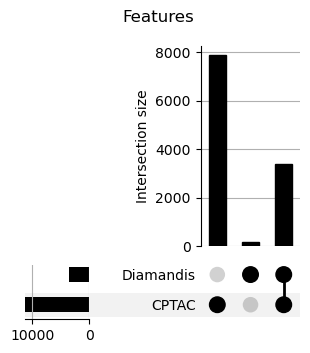

In [87]:
cn.plot_features_upset(integration)

A subset of these are identified as overdispersed in each dataset, and there is a significant overlap between datasets, indicating similar variation is seen in the two separate datasets.

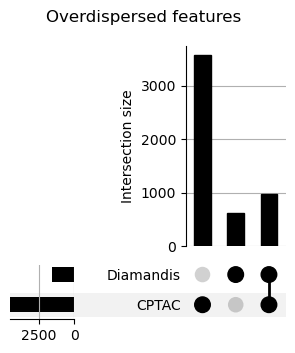

In [88]:
cn.plot_overdispersed_features_upset(integration)

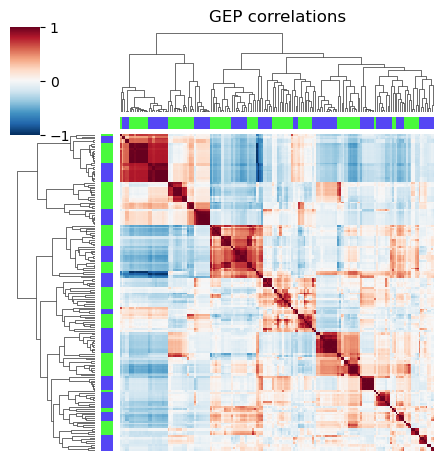

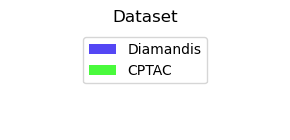

In [89]:
# plot the correlation matrix of all GEPs to each other
fig = cn.plot_gep_correlation_matrix(integration, colors=colors, figsize=[6, 6], hide_gep_labels=True)
fig.savefig("correlation_matrix.pdf")

# plot the legend separately as it applies to multiple figures
figlegend = colors.plot_dataset_colors_legend()
figlegend.savefig("datasets_legend.pdf")

To see if the `max_median_corr` threshold removed any ranks from either of the datasets, the following plot can be generated. The x-axis is the max-k, a threshold that excludes ranks above. The y-axis is the median of the correlation coefficients for all non-self edges in the correlation network. As this this threshold is slowly increased, the number of ranks, and thus nodes, and thus edges increases. The correlation between all edges slowly increases. In some datasets, this median of correlations will exceed 0 at high ranks. These high ranks will be excluded by this filter.

You can easily see for each rank whether there is a cNMF result, the stability/error of the result, as well as whether the ranks will be excluded on the basis of a max-k filter (derived from the max_median_corr parameter). You can also see which ranks will be selected (selected_k) based on automatic node subsetting for the final SNS maps.

In [90]:
integration.k_table

CPTAC                                                       \
   cNMF result max_k_filter_pass max_k_median_corr prediction_error   
2         True              True         -0.991495    297209.125000   
3         True              True         -0.452958    271564.250000   
4         True              True         -0.319994    255426.406250   
5         True              True         -0.256129    241623.500000   
6         True              True         -0.170240    232363.906250   
7         True              True         -0.158771    227380.046875   
8         True              True         -0.120251    221599.156250   
9          NaN              True         -0.119909              NaN   
10         NaN              True         -0.118909              NaN   
15         NaN              True         -0.100116              NaN   
20         NaN              True         -0.080802              NaN   

                          Diamandis                                      \
   selected_k stability cNMF result max_k_filter_pass max_k_median_corr   
2        True  0.991880        True              True         -0.999225   
3        True  0.794117        True              True         -0.433273   
4        True  0.739128        True              True         -0.181457   
5        True  0.711791        True              True         -0.136601   
6        True  0.650285        True              True         -0.129082   
7        True  0.518517        True              True         -0.115986   
8        True  0.431671        True              True         -0.106971   
9       False       NaN         NaN              True         -0.100031   
10      False       NaN         NaN              True         -0.091401   
15      False       NaN         NaN              True         -0.081420   
20      False       NaN         NaN              True         -0.072637   

                                          
   prediction_error selected_k stability  
2      87353.046875       True  0.995373  
3      73714.187500       True  0.962886  
4      68793.367188       True  0.736747  
5      63818.218750       True  0.676684  
6      59020.273438       True  0.760332  
7      55886.996094       True  0.826267  
8      53651.460938       True  0.724182  
9               NaN      False       NaN  
10              NaN      False       NaN  
15              NaN      False       NaN  
20              NaN      False       NaN

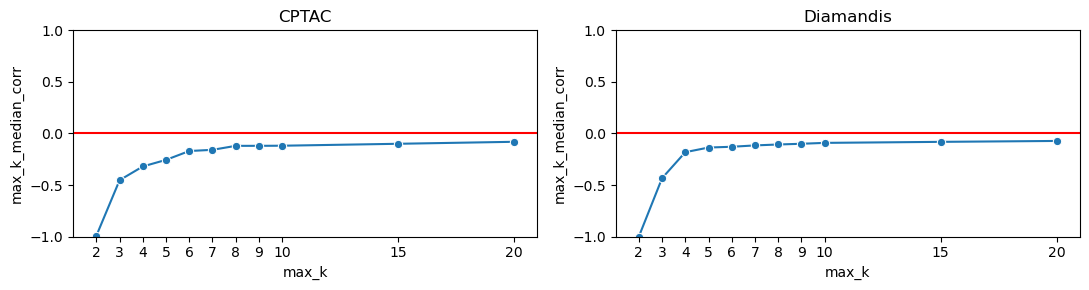

In [91]:
fig = cn.plot_rank_reduction(integration)

You can see that no k-values exceeded the threshold, so no max_k filter was applied. Now, let's plot the distribution of correlations for GEPs within and between datasets. This will show the min_corr thresholds. There is one threshold per dataset pair, and one threshold for within each dataset.

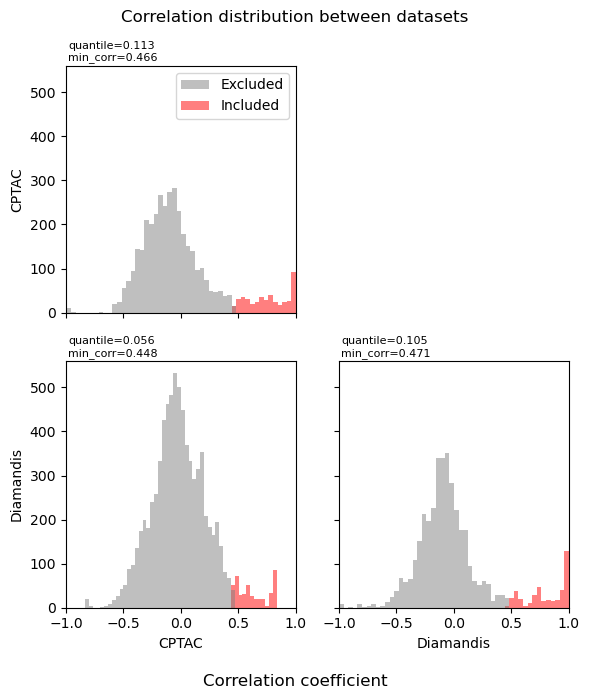

In [92]:
fig = cn.plot_pairwise_corr(integration)
# fig2 = cn.plot_pairwise_corr_overlaid(integration)  # overlaid plots show the mirrored distributions

See the number of nodes from each dataset with and without the node filters (including maxk and selectedk filters) and the edge filter (min_corr thresholds).

In [93]:
integration.get_node_table()

Node filter none         maxk         selectedk        
Edge Filter none mincorr none mincorr      none mincorr
CPTAC         89      89   89      89        35      35
Diamandis     89      89   89      89        35      35

## Create an SNS integration

2023-03-06 13:31:56,239 [INFO] Community search: algorithm = greedy_modularity, resolution = 1
2023-03-06 13:31:56,283 [INFO] Creating community network


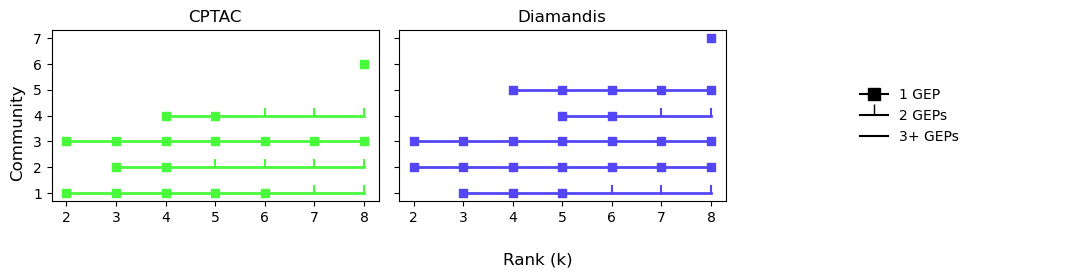

In [141]:
snsmap = cn.SNS(integration)
snsmap.community_search(algorithm="greedy_modularity", resolution=1)
fig = cn.plot_community_by_dataset_rank(snsmap, colors)

# Plot an SNS Map

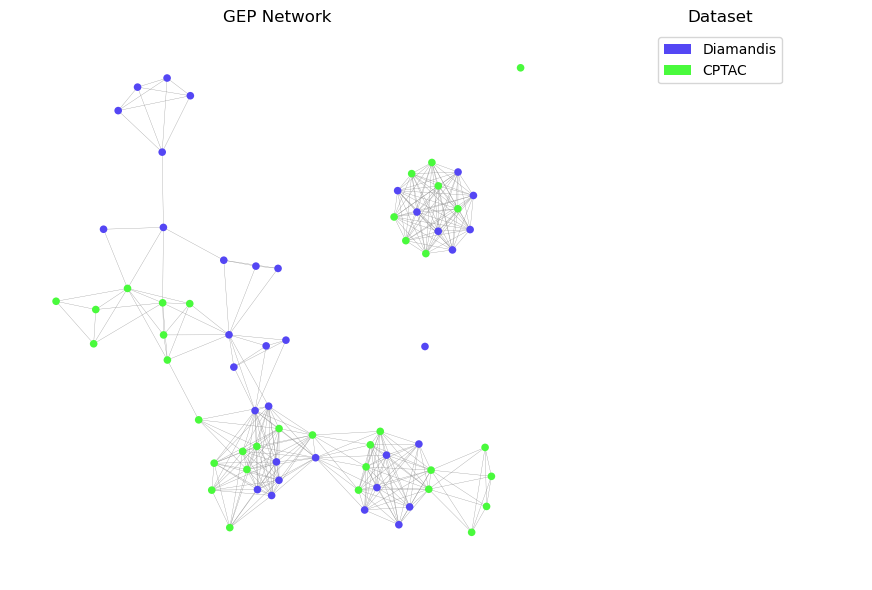

In [142]:
import cnmfsns as cn
snsmap.compute_layout(algorithm="neato")
fig = cn.plot_gep_network_datasets(snsmap, colors, node_size_kval=False)

How many samples have each GEP/node as their highest usage GEP? 

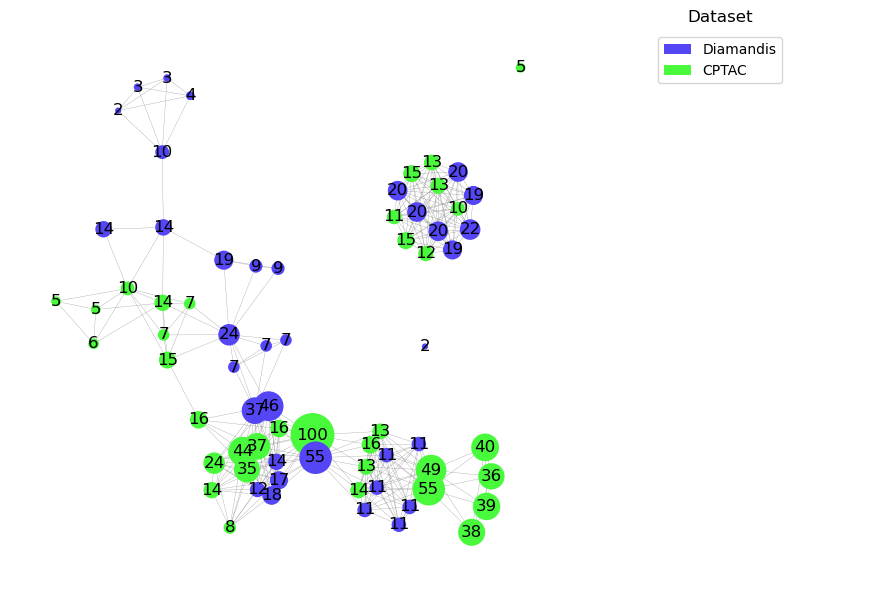

In [143]:
fig = cn.plot_gep_network_samples(snsmap,
                                  colors,
                                  node_size=1e3,
                                  font_size=12,
                                  discretize=True)

How many patients is each GEP primarily associated to?

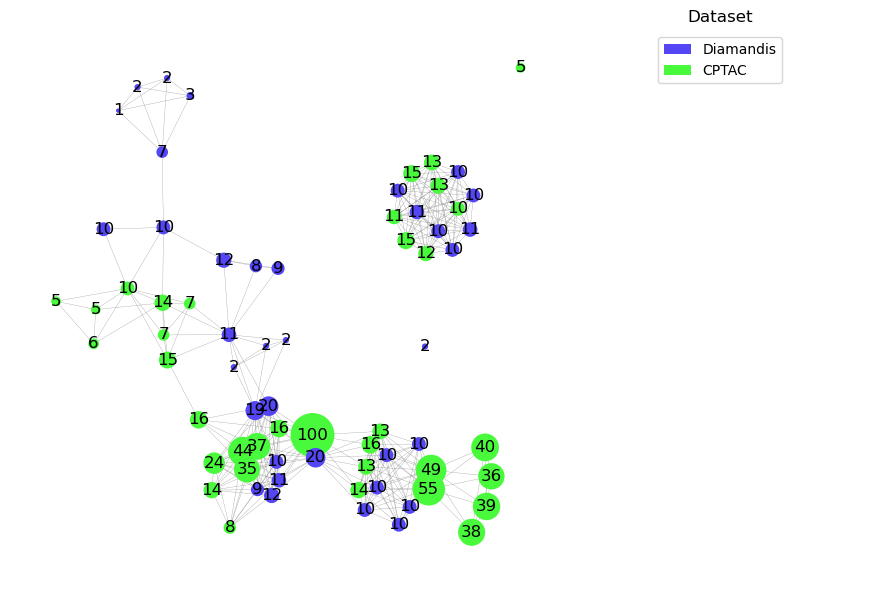

In [122]:
fig = cn.plots.plot_gep_network_patients(snsmap,
                                         colors,
                                         node_size=1e3,
                                         font_size=12)


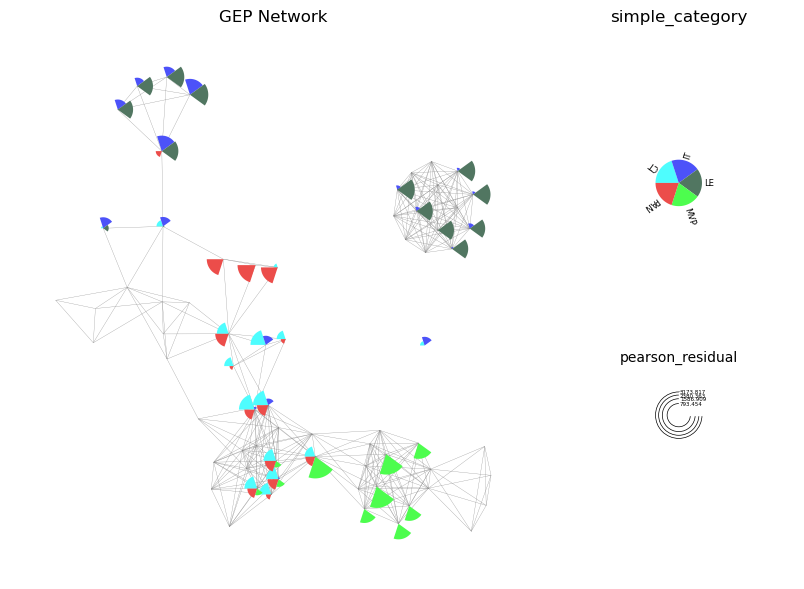

In [96]:
fig = cn.plot_gep_overrepresentation_network(snsmap, colors, subset_datasets="Diamandis", layer="simple_category")
fig.savefig("diamandis_overrepresentation.pdf")

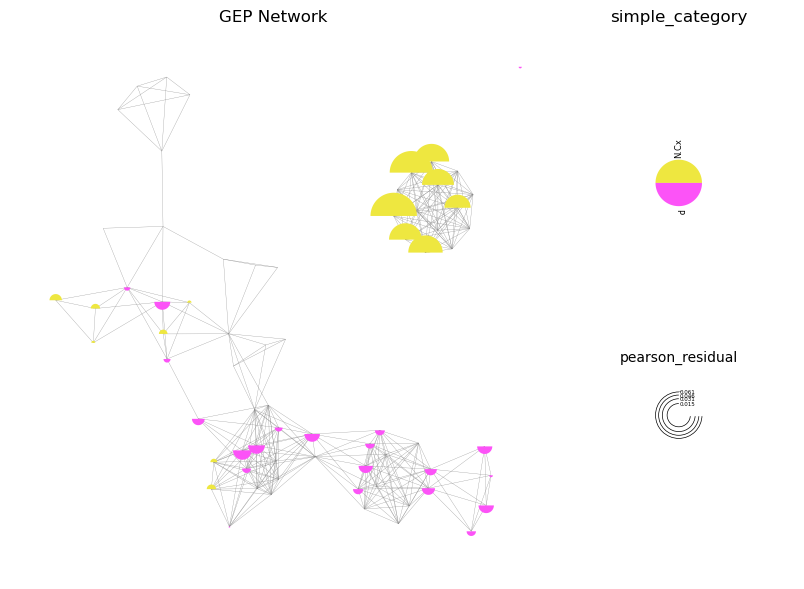

In [97]:
fig = cn.plot_gep_overrepresentation_network(snsmap, colors, subset_datasets="CPTAC", layer="simple_category")
fig.savefig("cptac_overrepresentation.pdf")

# GEP Communities

2023-03-06 13:32:14,577 [INFO] Choosing distinct community colors


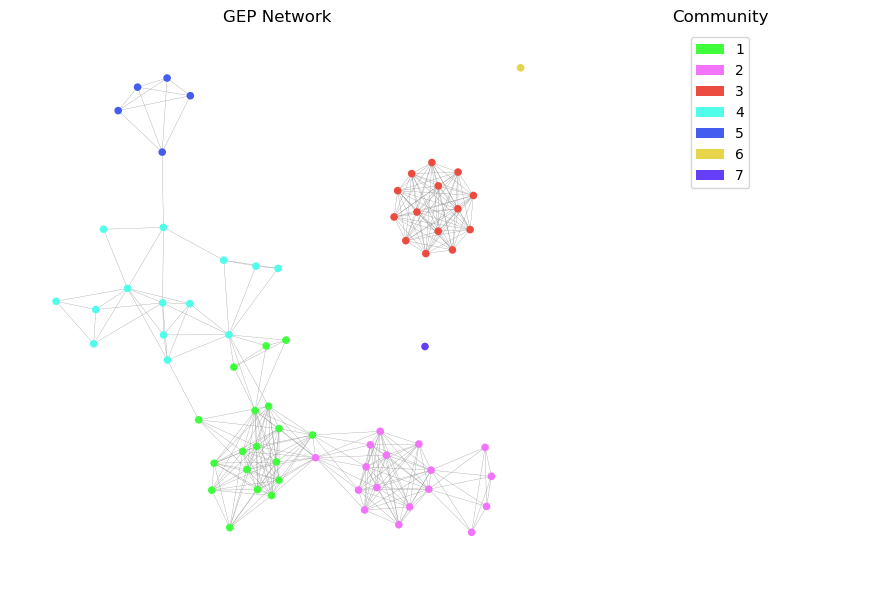

In [144]:
colors.add_missing_community_colors(snsmap)
fig = cn.plot_gep_network_communities(snsmap, colors)

Plot a summary showing the size of each community (node size) and number of edges connecting communities (edge width).

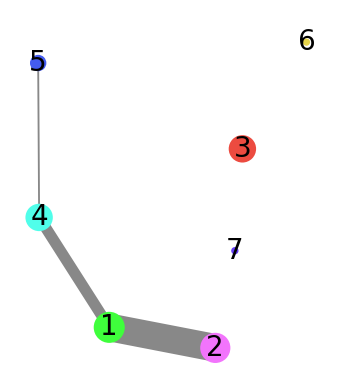

In [145]:
fig = cn.plot_community_network_summary(snsmap, colors)

Plot summarized GEP usage heatmap summarized by Community

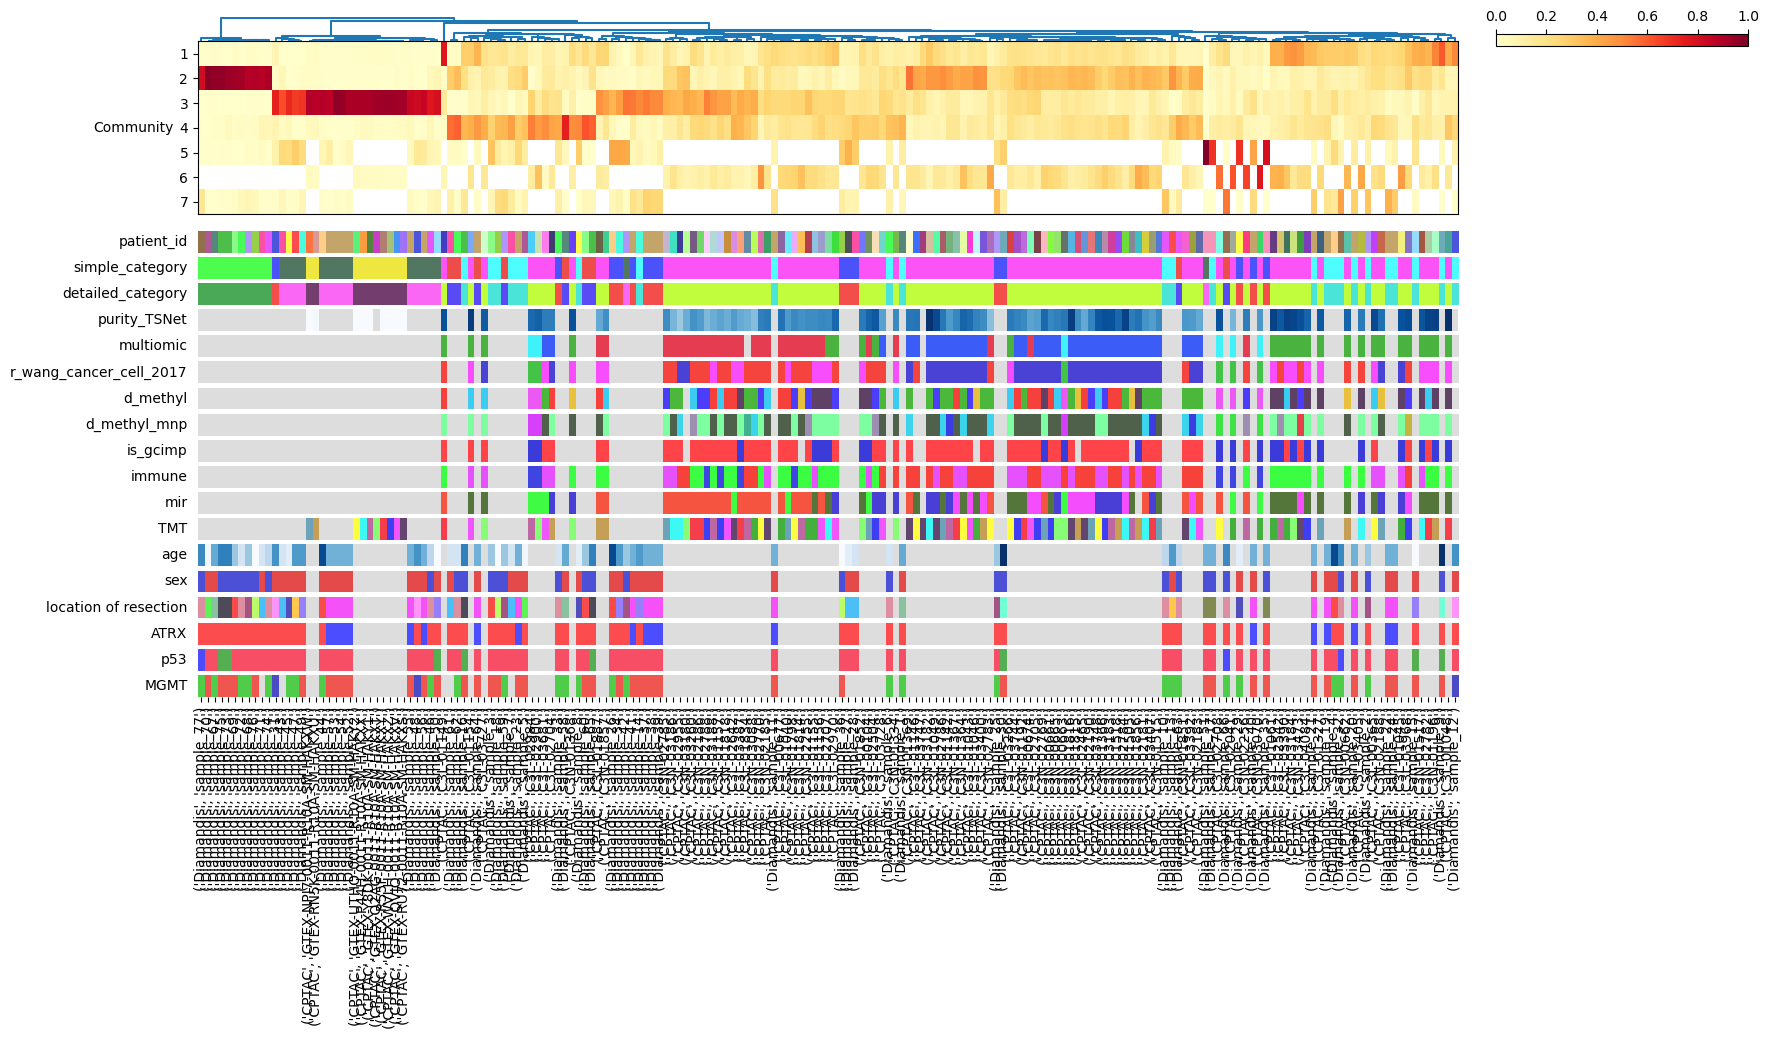

In [169]:
fig = cn.plots.plot_community_usage_heatmap(snsmap, colors)
# fig_legend = colors.plot_metadata_colors_legend()

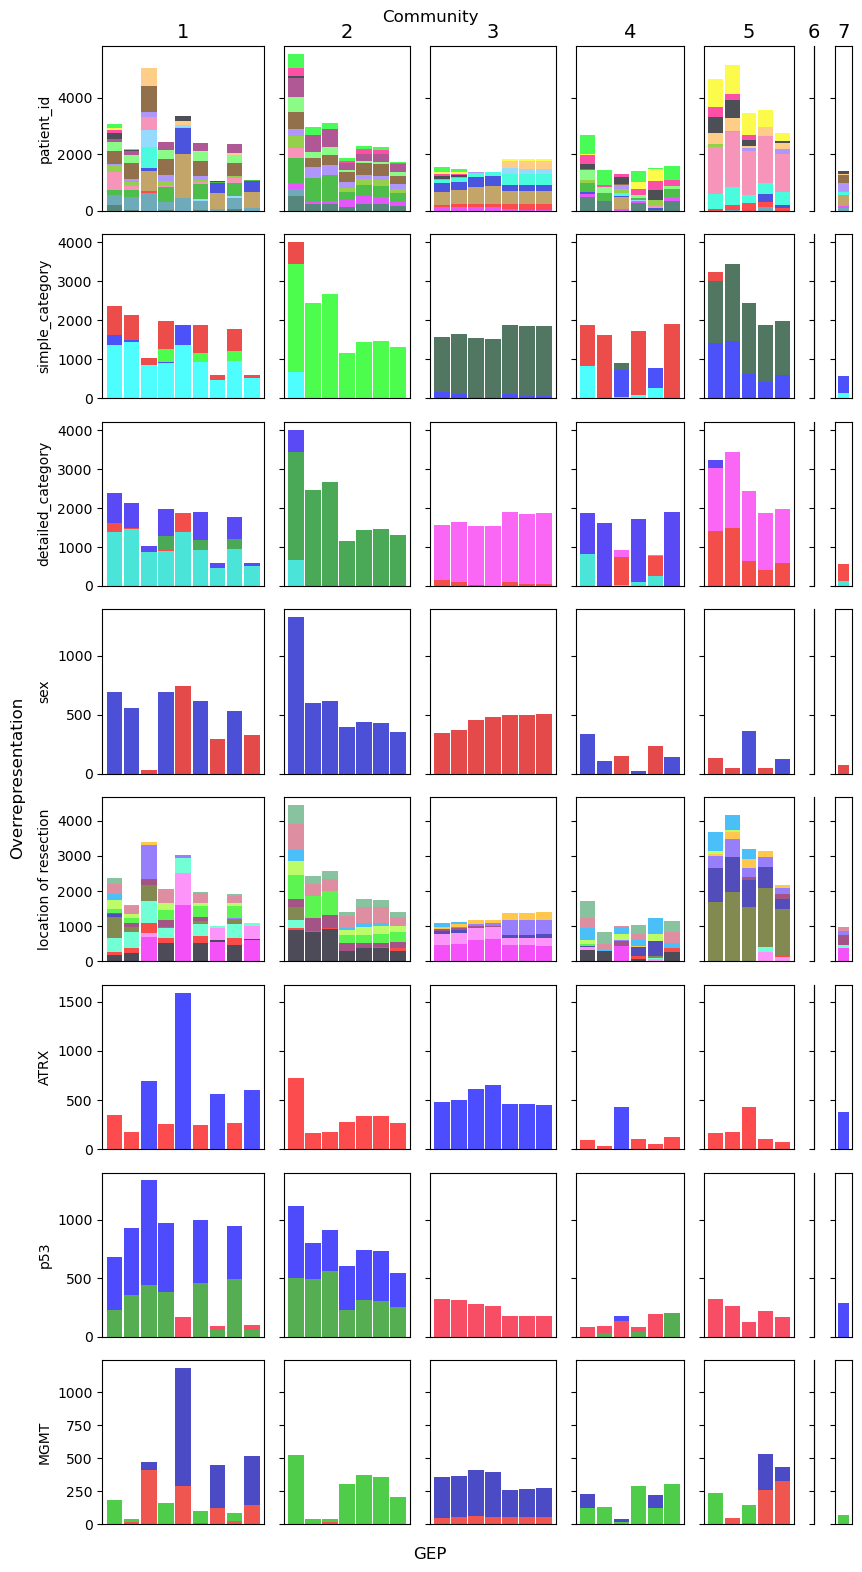

In [168]:
fig = cn.plot_overrepresentation_geps_bar(snsmap, colors, dataset_name="Diamandis")

# Community-level summary of overrepresentation